<a href="https://colab.research.google.com/github/nbhami2/GNN_Model/blob/main/GNN_Model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip install torch_geometric
!pip install mne
!pip install mne-connectivity
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data, DataLoader
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split

import os
import mne
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc, mutual_info_score
import matplotlib.pyplot as plt
from graphviz import Digraph
import mne_connectivity
import seaborn as sns
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
data_dir = '/content/drive/MyDrive/gnn_data'

In [ ]:
raw_data_path = os.path.join(data_dir, 'correlation_data.npz')
data_fd = np.load(raw_data_path)
X = data_fd['X']
y = data_fd['y']


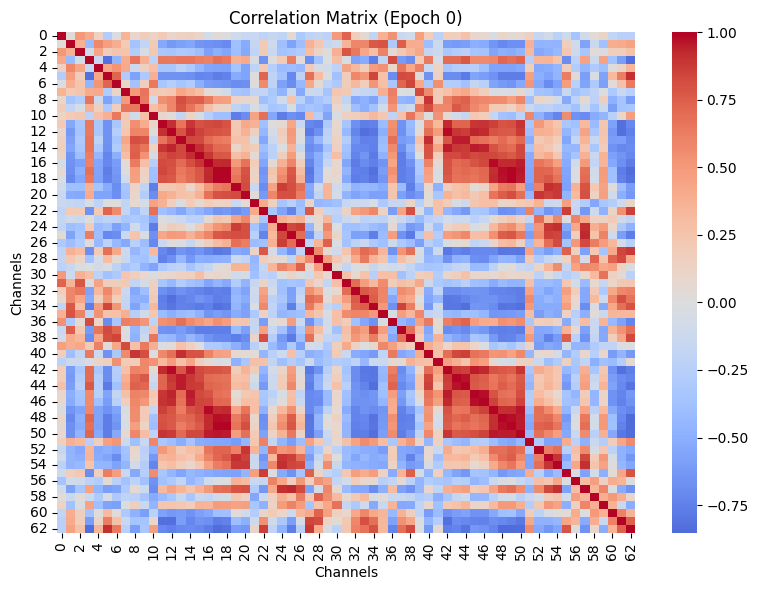

In [ ]:
i = 0
corr_matrix = X[i]

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title(f"Correlation Matrix (Epoch {i})")
plt.xlabel("Channels")
plt.ylabel("Channels")
plt.tight_layout()
plt.show()

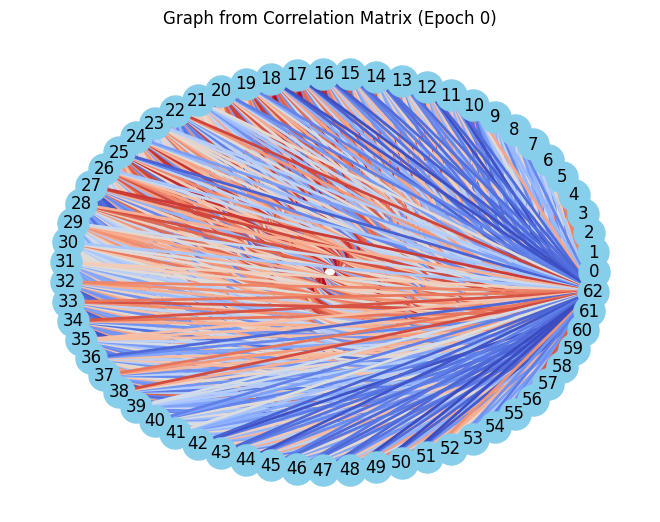

In [ ]:
G = nx.Graph()
num_nodes = corr_matrix.shape[0]
G.add_nodes_from(range(num_nodes))

for src in range(num_nodes):
    for dst in range(src + 1, num_nodes):
        weight = corr_matrix[src, dst]
        G.add_edge(src, dst, weight=weight)

to_plot = 0
pos = nx.circular_layout(G)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color=edge_weights, edge_cmap=plt.cm.coolwarm, width=2)
plt.title(f"Graph from Correlation Matrix (Epoch {to_plot})")
plt.show()

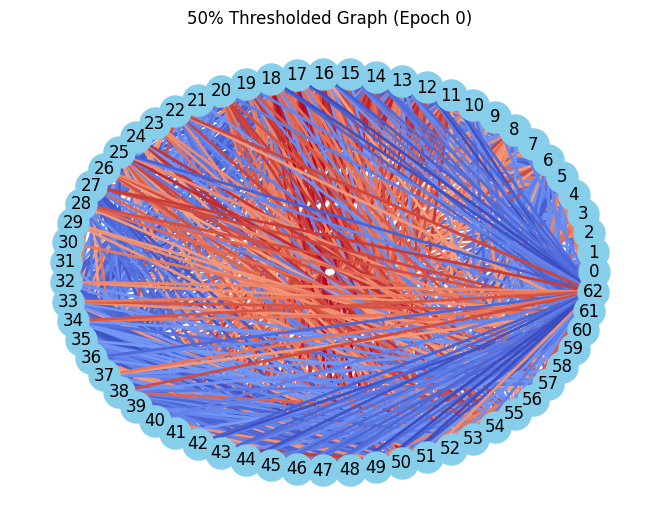

In [ ]:
G = nx.Graph()
num_nodes = corr_matrix.shape[0]
G.add_nodes_from(range(num_nodes))

threshold = 0.5
for src in range(num_nodes):
    for dst in range(src + 1, num_nodes):
        weight = corr_matrix[src, dst]
        if abs(weight) > threshold:
            G.add_edge(src, dst, weight=weight)

to_plot = 0
pos = nx.circular_layout(G)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color=edge_weights, edge_cmap=plt.cm.coolwarm, width=2)
plt.title(f"50% Thresholded Graph (Epoch {to_plot})")
plt.show()

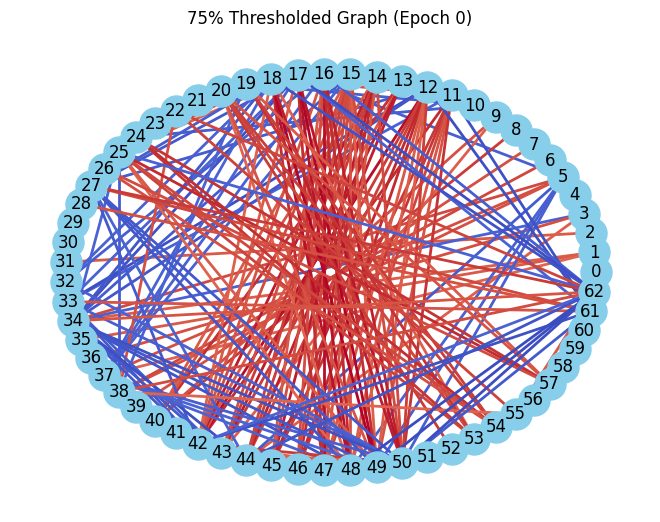

In [ ]:
G = nx.Graph()
num_nodes = corr_matrix.shape[0]
G.add_nodes_from(range(num_nodes))

threshold = 0.75
for src in range(num_nodes):
    for dst in range(src + 1, num_nodes):
        weight = corr_matrix[src, dst]
        if abs(weight) > threshold:
            G.add_edge(src, dst, weight=weight)

to_plot = 0
pos = nx.circular_layout(G)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color=edge_weights, edge_cmap=plt.cm.coolwarm, width=2)
plt.title(f"75% Thresholded Graph (Epoch {to_plot})")
plt.show()

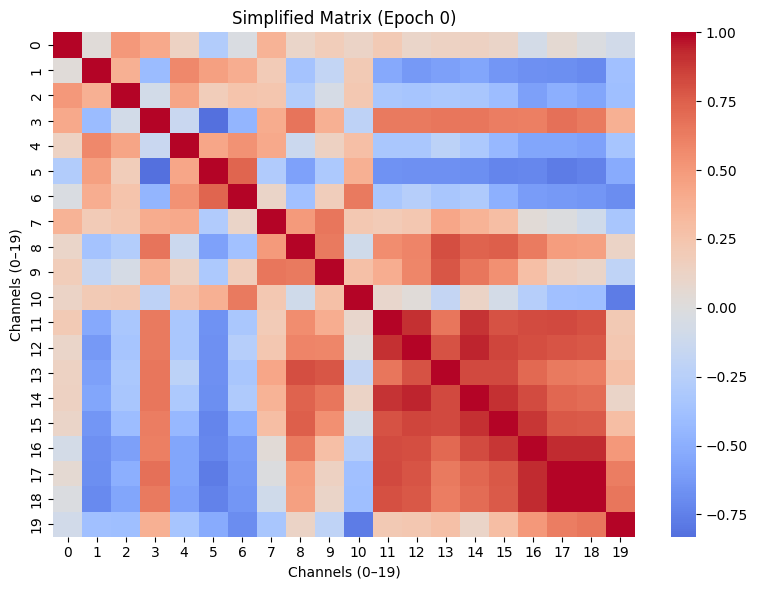

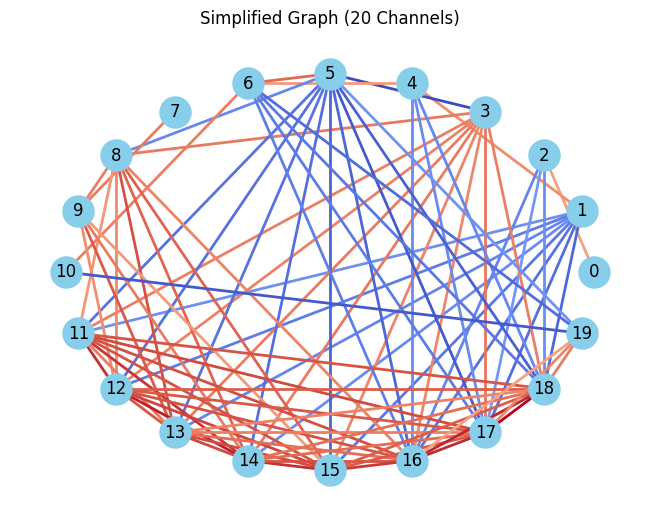

In [ ]:
# Simplified graph
corr_matrix_20 = X[to_plot][:20, :20]
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_20, annot=False, cmap='coolwarm', center=0)
plt.title(f"Simplified Matrix (Epoch {to_plot})")
plt.xlabel("Channels (0–19)")
plt.ylabel("Channels (0–19)")
plt.tight_layout()
plt.show()
G20 = nx.Graph()
num_nodes = 20
G20.add_nodes_from(range(num_nodes))

threshold = 0.5
for src in range(num_nodes):
    for dst in range(src + 1, num_nodes):
        weight = corr_matrix_20[src, dst]
        if abs(weight) > threshold:
            G20.add_edge(src, dst, weight=weight)

pos = nx.circular_layout(G20)
edge_weights = [G20[u][v]['weight'] for u, v in G20.edges()]

nx.draw(G20, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color=edge_weights, edge_cmap=plt.cm.coolwarm, width=2)
#For labels
# edge_labels = nx.get_edge_attributes(G20, 'weight')
# rounded_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
# nx.draw_networkx_edge_labels(G20, pos, edge_labels=rounded_labels, font_size=8)
plt.title("Simplified Graph (20 Channels)")
plt.show()

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, num_nodes, hidden_dim, output_dim, embedding_dim=16):
        super(GNN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, embedding_dim)
        self.conv1 = GCNConv(embedding_dim, hidden_dim, normalize=True)
        self.conv2 = GCNConv(hidden_dim, hidden_dim, normalize=True)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        edge_index, edge_attr, batch = data.edge_index, data.edge_attr, data.batch

        x = self.embedding(data.x.squeeze().long())
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_attr))
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
# def create_eeg_graph(num_channels=12, features_dim=5, label=None):
#     node_features = torch.rand((num_channels, features_dim), dtype=torch.float)

#     connectivity_matrix = np.random.rand(num_channels, num_channels)
#     connectivity_matrix = (connectivity_matrix + connectivity_matrix.T) / 2
#     np.fill_diagonal(connectivity_matrix, 0)

#     edge_indices = np.nonzero(connectivity_matrix)
#     edge_index = torch.tensor(np.array(edge_indices), dtype=torch.long)

#     edge_weights = torch.tensor(connectivity_matrix[edge_indices], dtype=torch.float)
#     node_labels = torch.tensor([label] * num_channels, dtype=torch.long)
#     return Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights, y=node_labels)


# # Create multiple graphs for dataset
# num_samples = 20
# labels = torch.tensor(np.random.randint(0, 2, num_samples), dtype=torch.long)  # Binary labels
# graphs = [create_eeg_graph(label=labels[i]) for i in range(num_samples)]  # Pass the label to create_eeg_graph


# train_graphs, val_graphs, train_labels, val_labels = train_test_split(graphs, labels, test_size=0.2, random_state=42)

# labels = torch.tensor(y, dtype=torch.long)
# graphs = torch.tensor(X, dtype=torch.float)
# train_graphs, val_graphs, train_labels, val_labels = train_test_split(graphs, labels, test_size=0.2, random_state=42)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split

graphs = []
for i in range(X.shape[0]):
    num_nodes = X.shape[1]
    edge_list = [[src, dst] for src in range(num_nodes) for dst in range(num_nodes) if src != dst]
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    edge_attr = torch.tensor([X[i, src, dst] for src, dst in edge_list], dtype=torch.float)
    edge_attr = (edge_attr + 1) / 2

    node_ids = torch.arange(num_nodes, dtype=torch.long)
    data = Data(
        x=node_ids.unsqueeze(1).float(),
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=torch.tensor(y[i], dtype=torch.long)
    )
    graphs.append(data)

# Split the data
train_graphs, val_graphs = train_test_split(graphs, test_size=0.2, random_state=42)

# Create DataLoaders
train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=16, shuffle=False)


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GNN(num_nodes=63, hidden_dim=16, output_dim=5)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
criterion = torch.nn.NLLLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

def train(model, loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            target = data.y.to(device)
            loss = criterion(output, target)
            loss.backward()

            optimizer.step()
            total_loss += loss.item()
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}, Accuracy: {accuracy:.4f}")

train(model, train_loader, optimizer, criterion, epochs=30)

Epoch 1, Loss: 1.5838, Accuracy: 0.2996
Epoch 2, Loss: 1.4895, Accuracy: 0.5974
Epoch 3, Loss: 1.4609, Accuracy: 0.5758
Epoch 4, Loss: 1.4309, Accuracy: 0.5700
Epoch 5, Loss: 1.4115, Accuracy: 0.5464
Epoch 6, Loss: 1.4005, Accuracy: 0.5276
Epoch 7, Loss: 1.3882, Accuracy: 0.5345
Epoch 8, Loss: 1.3762, Accuracy: 0.5367
Epoch 9, Loss: 1.3649, Accuracy: 0.5312
Epoch 10, Loss: 1.3541, Accuracy: 0.5426
Epoch 11, Loss: 1.3451, Accuracy: 0.5405
Epoch 12, Loss: 1.3370, Accuracy: 0.5466
Epoch 13, Loss: 1.3199, Accuracy: 0.5448
Epoch 14, Loss: 1.3070, Accuracy: 0.5462
Epoch 15, Loss: 1.2892, Accuracy: 0.5386
Epoch 16, Loss: 1.2757, Accuracy: 0.5473
Epoch 17, Loss: 1.2594, Accuracy: 0.5398
Epoch 18, Loss: 1.2420, Accuracy: 0.5487
Epoch 19, Loss: 1.2351, Accuracy: 0.5521
Epoch 20, Loss: 1.2196, Accuracy: 0.5514
Epoch 21, Loss: 1.1994, Accuracy: 0.5663
Epoch 22, Loss: 1.1898, Accuracy: 0.5611
Epoch 23, Loss: 1.1807, Accuracy: 0.5696
Epoch 24, Loss: 1.1730, Accuracy: 0.5674
Epoch 25, Loss: 1.1600, A

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            targets = data.y[0].repeat(output.shape[0])
            loss = criterion(output, targets)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    print(f"Validation Accuracy: {correct / total:.2%}")
    print(f"Validation Loss: {loss.item():.4f}")

evaluate(model, val_loader)

Validation Accuracy: 44.97%
Validation Loss: 0.7180


In [ ]:
# Confusion Matrix

In [ ]:
#------------------------------------------------
# Make Prediction
def predict_stroke(model, corr_matrix):
  model.eval()
  num_nodes = corr_matrix.shape[0]

  edge_list = [[src, dst] for src in range(num_nodes) for dst in range(num_nodes) if src != dst]
  edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

  edge_attr = torch.tensor([corr_matrix[src, dst] for src, dst in edge_list], dtype=torch.float)
  edge_attr = (edge_attr + 1) / 2

  node_ids = torch.arange(num_nodes, dtype=torch.long)
  data = Data(
      x=node_ids.unsqueeze(1).float(),
      edge_index=edge_index,
      edge_attr=edge_attr,
  )

  data = data.to(next(model.parameters()).device)
  with torch.no_grad():
    output = model(data)
    pred = output.argmax(dim=1).item()
  return pred


In [ ]:
#------------------------------------------------
# Edge Importance
data = data.to(device)
model.eval()

data.edge_attr.requires_grad_(True)
output = model(data)

pred = output.argmax(dim=1)
score = output[0, pred]
score.backward()

importance = data.edge_attr.grad.abs().detach().cpu().numpy()

edges = data.edge_index.t().detach().cpu().numpy()

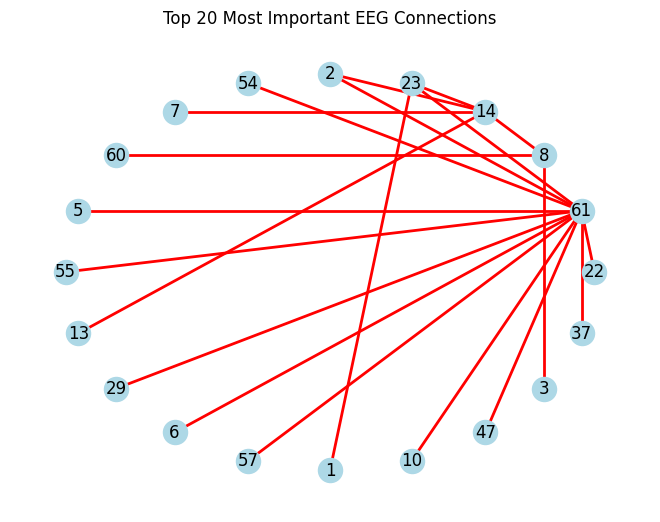

In [ ]:
G = nx.Graph()
G.add_edges_from([tuple(edge) for edge in edges])

for (u, v), weight in zip(edges, importance):
    G[u][v]['weight'] = weight

topk = 20
important_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:topk]
subG = nx.Graph()
subG.add_edges_from([(u, v) for u, v, _ in important_edges])

pos = nx.circular_layout(subG)
nx.draw(subG, pos, with_labels=True, node_color='lightblue', edge_color='red', width=2)
plt.title(f"Top {topk} Most Important EEG Connections")
plt.show()